In [1]:
# Stage 7 — Outlier Analysis (Project)
import os, sys, numpy as np, pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Make ../src importable
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT / "src"))

RAW  = PROJECT_ROOT / "data" / "raw"
PROC = PROJECT_ROOT / "data" / "processed"
PROC.mkdir(parents=True, exist_ok=True)

RAW, PROC


(PosixPath('/Users/brian/bootcamp_Brian_Chang/project/data/raw'),
 PosixPath('/Users/brian/bootcamp_Brian_Chang/project/data/processed'))

In [2]:
# Load the latest preprocessed prices file saved in Stage 6
def latest(pattern: str) -> Path | None:
    files = sorted(PROC.glob(pattern))
    return files[-1] if files else None
path = latest("prices_*.csv")
print(path)
df = pd.read_csv(path)
print("Loaded:", path.name, "rows:", len(df))
df.head()


/Users/brian/bootcamp_Brian_Chang/project/data/processed/prices_preprocessed_20250820-120204.csv
Loaded: prices_preprocessed_20250820-120204.csv rows: 250


,date,open,high,low,close,volume,Dividends,Stock Splits,ret_1d,ret_1d_z
0,2024-08-16 00:00:00-04:00,222.882700,225.779224,222.613947,225.002838,44340200,0.0,0.0,NaN,NaN
1,2024-08-19 00:00:00-04:00,224.674371,224.943125,222.006778,224.843582,40687800,0.0,0.0,-0.070780,-0.050741
2,2024-08-20 00:00:00-04:00,224.724146,226.117655,224.405621,225.460709,30299000,0.0,0.0,0.274469,0.120104
3,2024-08-21 00:00:00-04:00,225.470651,226.923879,224.007459,225.351196,34765500,0.0,0.0,-0.048573,-0.039752
4,2024-08-22 00:00:00-04:00,226.734776,227.282232,222.862797,223.489883,43695300,0.0,0.0,-0.825961,-0.424439


In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))  # allows `from src...` when running from notebooks/

from src.outliers import detect_outliers_iqr, detect_outliers_zscore

target = "ret_1d"  # we only analyze raw daily returns here, because we have done normalization in Stage 6
assert target in df.columns, f"'{target}' not found in df.columns"

# Flag outliers (you can pick either method; we’ll compute both and use IQR as default)
df["outlier_iqr"] = detect_outliers_iqr(df[target], k=1.5)
df["outlier_z"]   = detect_outliers_zscore(df[target], threshold=3.0)

print("Flag rates (fraction of rows):")
print(df[["outlier_iqr","outlier_z"]].mean().rename("fraction_flagged"))

print("\nOverlap counts:")
print(pd.crosstab(df['outlier_iqr'], df['outlier_z']))


Flag rates (fraction of rows):
outlier_iqr    0.084
outlier_z      0.016
Name: fraction_flagged, dtype: float64

Overlap counts:
outlier_z    False  True 
outlier_iqr              
False          229      0
True            17      4


In [4]:
def summarize(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    return pd.Series({
        "mean":   s.mean(),
        "median": s.median(),
        "std":    s.std()
    })

# Compare ALL vs IQR-filtered (and Z-filtered just for reference)
summ_all = summarize(df[target])
summ_iqr = summarize(df.loc[~df["outlier_iqr"], target])
summ_z   = summarize(df.loc[~df["outlier_z"],   target])

comp = pd.concat(
    {"all": summ_all, "filtered_iqr": summ_iqr, "filtered_z": summ_z},
    axis=1
)
comp.T  # methods as rows, metrics as columns


,mean,median,std
all,0.031760,0.114025,2.024903
filtered_iqr,0.092742,0.118700,1.214030
filtered_z,0.011425,0.114025,1.572850


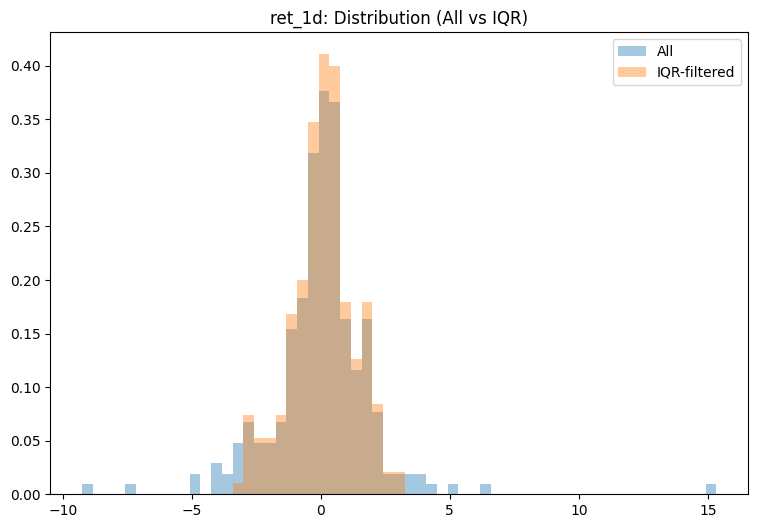

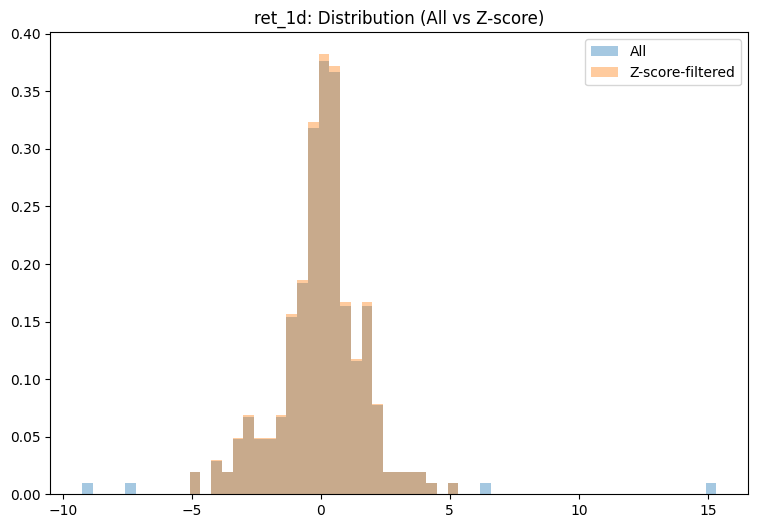

In [5]:
vals_all = pd.to_numeric(df[target], errors="coerce").dropna()
vals_iqr = pd.to_numeric(df.loc[~df["outlier_iqr"], target], errors="coerce").dropna()
vals_z   = pd.to_numeric(df.loc[~df["outlier_z"],   target], errors="coerce").dropna()

bins = np.linspace(vals_all.min(), vals_all.max(), 60)

plt.figure(figsize=(9,6))
plt.hist(vals_all, bins=bins, alpha=0.4, density=True, label="All")
plt.hist(vals_iqr, bins=bins, alpha=0.4, density=True, label="IQR-filtered")
plt.title(f"{target}: Distribution (All vs IQR)")
plt.legend()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(vals_all, bins=bins, alpha=0.4, density=True, label="All")
plt.hist(vals_z,   bins=bins, alpha=0.4, density=True, label="Z-score-filtered")
plt.title(f"{target}: Distribution (All vs Z-score)")
plt.legend()
plt.show()


/var/folders/hc/lx21f3657gz88_xv7kjd578w0000gn/T/ipykernel_59288/1652915966.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([vals_all, vals_iqr, vals_z], labels=["All", "IQR-filtered", "Z-score-filtered"])


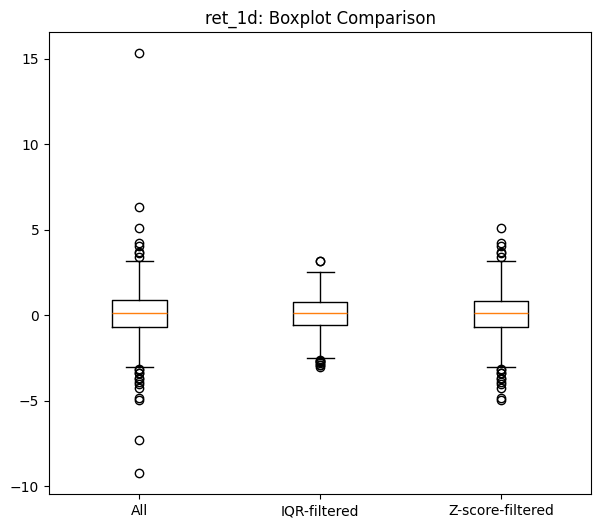

In [6]:
plt.figure(figsize=(7,6))
plt.boxplot([vals_all, vals_iqr, vals_z], labels=["All", "IQR-filtered", "Z-score-filtered"])
plt.title(f"{target}: Boxplot Comparison")
plt.show()
